In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pyspark.sql.functions import datediff, current_date, year, month, quarter, when, col, sum, count, avg, concat_ws, floor
from scipy.stats import ttest_ind, shapiro, kstest, mannwhitneyu
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [0]:
# Display the list of tables in your catalog
spark.sql("SHOW TABLES IN default").show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|bronze_payments|      false|
| default|  bronze_riders|      false|
| default|bronze_stations|      false|
| default|   bronze_trips|      false|
| default|       payments|      false|
| default|         riders|      false|
| default|       stations|      false|
| default|          trips|      false|
+--------+---------------+-----------+



In [0]:
# Write each table to the Bronze Layer in Delta format
bronze_path = "/hive_metastore/default/bronze"

spark.sql("SELECT * FROM riders").write.format("delta").mode("overwrite").save(f"{bronze_path}/riders")
spark.sql("SELECT * FROM payments").write.format("delta").mode("overwrite").save(f"{bronze_path}/payments")
spark.sql("SELECT * FROM stations").write.format("delta").mode("overwrite").save(f"{bronze_path}/stations")
spark.sql("SELECT * FROM trips").write.format("delta").mode("overwrite").save(f"{bronze_path}/trips")

# Register the Bronze tables in the metastore
spark.sql(f"CREATE TABLE bronze_riders USING DELTA LOCATION '{bronze_path}/riders'")
spark.sql(f"CREATE TABLE bronze_payments USING DELTA LOCATION '{bronze_path}/payments'")
spark.sql(f"CREATE TABLE bronze_stations USING DELTA LOCATION '{bronze_path}/stations'")
spark.sql(f"CREATE TABLE bronze_trips USING DELTA LOCATION '{bronze_path}/trips'")

DataFrame[]

+----------+
|total_rows|
+----------+
|   4584921|
+----------+

+----------------+-------------+-------------------+-------------------+----------------+--------------+--------+
|         trip_id|rideable_type|         started_at|           ended_at|start_station_id|end_station_id|rider_id|
+----------------+-------------+-------------------+-------------------+----------------+--------------+--------+
|222BB8E5059252D7| classic_bike|2021-06-13 09:48:47|2021-06-13 10:07:23|    KA1503000064|         13021|   34062|
|1826E16CB5486018| classic_bike|2021-06-21 22:59:13|2021-06-21 23:04:29|    TA1306000010|         13021|    5342|
|3D9B6A0A5330B04D| classic_bike|2021-06-18 16:06:42|2021-06-18 16:12:02|    TA1305000030|         13021|    3714|
|07E82F5E9C9E490F| classic_bike|2021-06-17 16:46:23|2021-06-17 17:02:45|    TA1305000034|         13021|   18793|
|A8E94BAECBF0C2DD|  docked_bike|2021-06-13 17:36:29|2021-06-13 18:30:39|    TA1308000009|  TA1308000009|   43342|
|378F4AB323AA1D14|  do

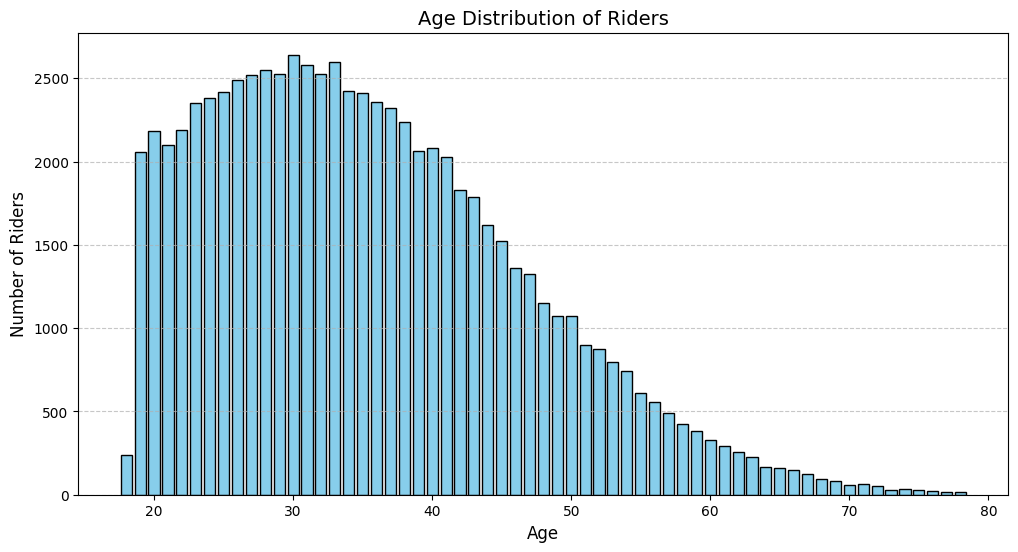

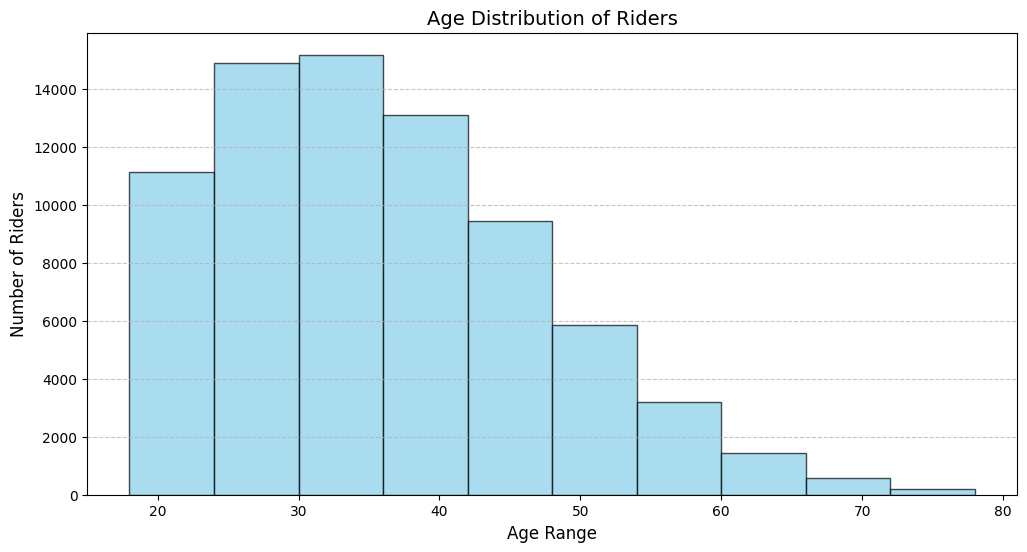

In [0]:
## EDA for trips
# Get the total number of rows
total_rows = spark.sql("SELECT COUNT(*) AS total_rows FROM bronze_trips")
total_rows.show()

# Preview the first few rows
spark.sql("SELECT * FROM bronze_trips LIMIT 10").show()

# Check for missing values
missing_values = spark.sql("""
SELECT 
    COUNT(*) AS total_rows,
    SUM(CASE WHEN trip_id IS NULL THEN 1 ELSE 0 END) AS missing_trip_id,
    SUM(CASE WHEN started_at IS NULL THEN 1 ELSE 0 END) AS missing_started_at,
    SUM(CASE WHEN ended_at IS NULL THEN 1 ELSE 0 END) AS missing_ended_at,
    SUM(CASE WHEN start_station_id IS NULL THEN 1 ELSE 0 END) AS missing_start_station_id,
    SUM(CASE WHEN end_station_id IS NULL THEN 1 ELSE 0 END) AS missing_end_station_id
FROM bronze_trips
""")
missing_values.show()

# Check for negative or extreme trip durations
invalid_durations = spark.sql("""
SELECT 
    trip_id,
    started_at,
    ended_at,
    DATEDIFF(SECOND, started_at, ended_at) / 60 AS trip_duration
FROM bronze_trips
WHERE DATEDIFF(SECOND, started_at, ended_at) / 60 < 0
   OR DATEDIFF(SECOND, started_at, ended_at) / 60 > 1440
""")
invalid_durations.show()

membership_breakdown = spark.sql("""
SELECT 
    is_member, 
    COUNT(*) AS total_riders
FROM bronze_riders
GROUP BY is_member
""")
membership_breakdown.show()

age_distribution = spark.sql("""
SELECT 
    FLOOR((DATEDIFF(CURRENT_DATE, birthday) / 365)) AS age,
    COUNT(*) AS total_riders
FROM bronze_riders
GROUP BY age
ORDER BY age
""").toPandas()

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(age_distribution['age'], age_distribution['total_riders'], color='skyblue', edgecolor='black')
plt.title("Age Distribution of Riders", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Number of Riders", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Prepare data for histogram
ages = age_distribution['age'].repeat(age_distribution['total_riders'])

# Plot a histogram
plt.figure(figsize=(12, 6))
plt.hist(ages, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Age Distribution of Riders", fontsize=14)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Number of Riders", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [0]:
# Load Bronze Trips
bronze_trips = spark.table("bronze_trips")

# Clean and transform
silver_trips = (
    bronze_trips
    .filter("started_at IS NOT NULL AND ended_at IS NOT NULL")  # Remove rows with missing timestamps
    .dropDuplicates(["trip_id"])  # Remove duplicate trip IDs
    .selectExpr(
        "trip_id",
        "rideable_type",
        "started_at",
        "ended_at",
        "DATEDIFF(SECOND, started_at, ended_at) / 60 AS trip_duration",
        "start_station_id",
        "end_station_id",
        "rider_id"
    )
)

# Save to Silver Layer
silver_trips.write.format("delta").mode("overwrite").saveAsTable("silver_trips")

In [0]:
# Load Bronze Riders
bronze_riders = spark.table("bronze_riders")

# Clean and transform
silver_riders = (
    bronze_riders
    .filter("rider_id IS NOT NULL AND birthday IS NOT NULL")  # Remove rows with missing critical fields
    .withColumn("age", (datediff(current_date(), "birthday") / 365).cast("int"))  # Add age column
    .select(
        "rider_id",
        "first",
        "last",
        "address",
        "birthday",
        "account_start_date",
        "account_end_date",
        "is_member",
        "age"
    )
)

# Save to Silver Layer
silver_riders.write.format("delta").mode("overwrite").saveAsTable("silver_riders")

In [0]:
# Load Bronze Payments
bronze_payments = spark.table("bronze_payments")

# Clean and transform
silver_payments = (
    bronze_payments
    .filter("payment_id IS NOT NULL AND amount > 0")  # Remove rows with missing or invalid payments
    .select(
        "payment_id",
        "date",
        "amount",
        "rider_id"
    )
)

# Save to Silver Layer
silver_payments.write.format("delta").mode("overwrite").saveAsTable("silver_payments")

In [0]:
# Load Bronze Stations
bronze_stations = spark.table("bronze_stations")

# Clean and transform
silver_stations = (
    bronze_stations
    .filter("station_id IS NOT NULL AND latitude IS NOT NULL AND longitude IS NOT NULL")  # Ensure valid data
    .select(
        "station_id",
        "name",
        "latitude",
        "longitude"
    )
)

# Save to Silver Layer
silver_stations.write.format("delta").mode("overwrite").saveAsTable("silver_stations")

In [0]:
# Load Silver Tables
silver_trips = spark.table("silver_trips")
silver_riders = spark.table("silver_riders")

# Enrich Trips with Additional Time and Rider Info
gold_rides = (
    silver_trips
    .join(silver_riders, "rider_id")
    .withColumn("day_of_week", dayofweek("started_at"))  # Day of the week (1 = Sunday, ..., 7 = Saturday)
    .withColumn("time_of_day",  # Define time of day based on hours
                when(hour("started_at").between(0, 5), "Late Night")
                .when(hour("started_at").between(6, 11), "Morning")
                .when(hour("started_at").between(12, 17), "Afternoon")
                .when(hour("started_at").between(18, 23), "Evening")
                .otherwise("Unknown"))
    .withColumn("age_at_ride", (datediff("started_at", "birthday") / 365).cast("int"))  # Age at time of ride
    .select(
        "trip_id",
        "start_station_id",
        "end_station_id",
        "day_of_week",
        "time_of_day",
        "age_at_ride",
        "is_member",
        "trip_duration"
    )
)

# Save to Gold Layer
gold_rides.write.format("delta").mode("overwrite").saveAsTable("gold_rides")

In [0]:
# Load Silver Payments and Riders
silver_payments = spark.table("silver_payments")
silver_riders = spark.table("silver_riders")

# Aggregate Spending Metrics
gold_spending = (
    silver_payments
    .join(silver_riders, "rider_id")
    .withColumn("year", year("date"))
    .withColumn("quarter", quarter("date"))
    .withColumn("month", month("date"))
    .withColumn("age_at_account_start", (datediff("account_start_date", "birthday") / 365).cast("int"))
    .groupBy("year", "quarter", "month", "rider_id", "age_at_account_start", "is_member")
    .agg(
        sum(col("amount").cast("double")).alias("total_spent")
    )
)

# Save to Gold Layer
gold_spending.write.format("delta").mode("overwrite").saveAsTable("gold_spending")

In [0]:
# Compute Rides Per Month
rides_per_month = (
    silver_trips
    .withColumn("month_year", concat_ws("-", year("started_at"), month("started_at")))
    .groupBy("rider_id", "month_year")
    .agg(
        count("trip_id").alias("rides_in_month"),
        sum("trip_duration").alias("minutes_in_month")
    )
)

# Compute Average Rides and Minutes Per Month
avg_rides_and_minutes = (
    rides_per_month
    .groupBy("rider_id")
    .agg(
        avg("rides_in_month").alias("avg_rides_per_month"),
        avg("minutes_in_month").alias("avg_minutes_per_month")
    )
)

# Join with Spending Metrics
gold_extra_credit = (
    avg_rides_and_minutes
    .join(gold_spending, "rider_id")
    .select(
        "rider_id",
        "avg_rides_per_month",
        "avg_minutes_per_month",
        "total_spent"
    )
)

# Save to Gold Layer
gold_extra_credit.write.format("delta").mode("overwrite").saveAsTable("gold_extra_credit")

In [0]:
spark.sql("""SELECT * FROM gold_rides LIMIT 10;""").show()
spark.sql("""SELECT * FROM gold_spending LIMIT 10;""").show()
spark.sql("""SELECT * FROM gold_extra_credit LIMIT 10;""").show()

+----------------+----------------+--------------+-----------+-----------+-----------+---------+------------------+
|         trip_id|start_station_id|end_station_id|day_of_week|time_of_day|age_at_ride|is_member|     trip_duration|
+----------------+----------------+--------------+-----------+-----------+-----------+---------+------------------+
|69D3FE219C1C5E58|    KA1503000059|  TA1308000009|          6|  Afternoon|         24|     true| 4.766666666666667|
|DE7D9AC2412A3F78|    KA1503000043|         13021|          6|  Afternoon|         20|    false|              3.15|
|CD5FF8486A2AE434|    TA1308000049|         13021|          7|  Afternoon|         44|     true|             23.75|
|8D8511E47B4C6B6B|           13143|         13257|          7|    Evening|         24|     true|              26.9|
|5A91B1F56B24D18C|    KA1504000135|         13434|          5|    Evening|         19|     true|33.666666666666664|
|DFE8BD2F817D2344|           13158|         13257|          6|    Evenin

+-----------+-----------+------------------+
|day_of_week|time_of_day| avg_trip_duration|
+-----------+-----------+------------------+
|          1|  Afternoon|28.384439840288646|
|          1|    Evening|  27.0906408625922|
|          1| Late Night|  30.0107082826175|
|          1|    Morning|26.287865574768233|
|          2|  Afternoon| 21.91133263433944|
|          2|    Evening| 20.33681979380934|
|          2| Late Night|29.556833045305133|
|          2|    Morning| 17.34182636929111|
|          3|  Afternoon| 18.98274817050981|
|          3|    Evening| 19.21143693322341|
|          3| Late Night|22.367457154244725|
|          3|    Morning|15.176255791670481|
|          4|  Afternoon| 19.02490156243597|
|          4|    Evening|18.814619648357233|
|          4| Late Night|22.586930339591824|
|          4|    Morning|14.983566199639126|
|          5|  Afternoon| 18.78333015463659|
|          5|    Evening| 19.88460603777299|
|          5| Late Night|19.557899818949924|
|         

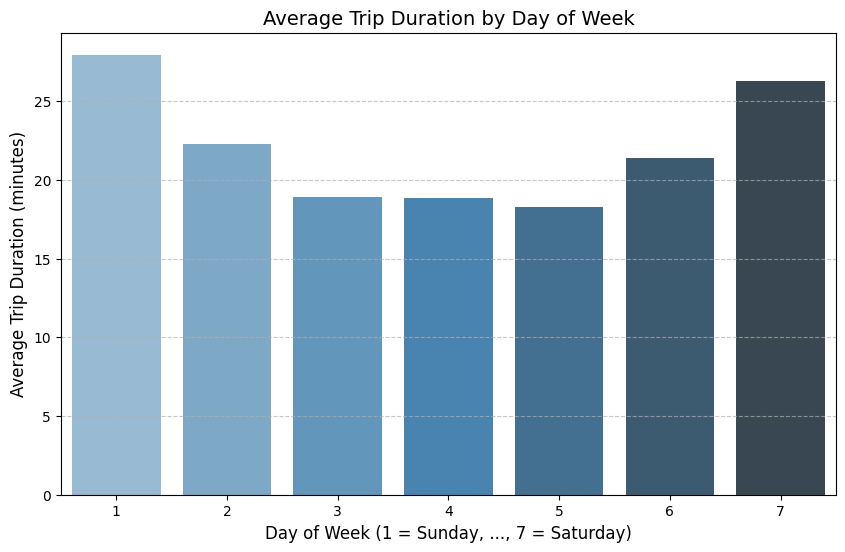

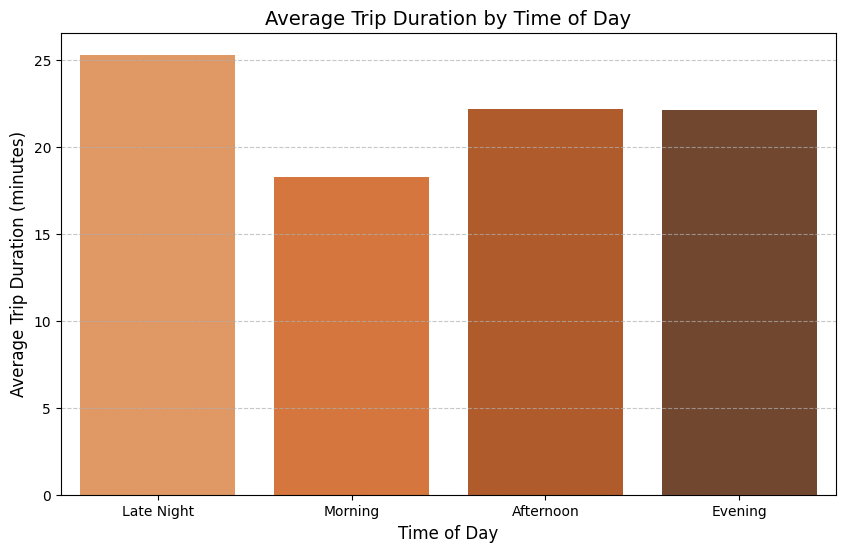

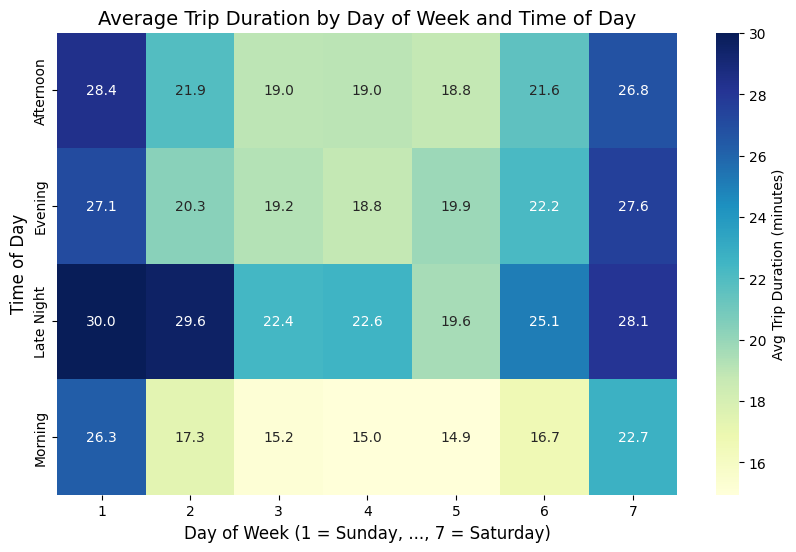

In [0]:
# 1. How much time is spent per ride based on Date and Time Factors (Day of Week and Time of Day)
spark.sql("""
SELECT 
    day_of_week,
    time_of_day,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
GROUP BY day_of_week, time_of_day
ORDER BY day_of_week, time_of_day;
""").show()

# Fetch query result into a Pandas DataFrame
query_result = spark.sql("""
SELECT 
    day_of_week,
    time_of_day,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
GROUP BY day_of_week, time_of_day
ORDER BY day_of_week, time_of_day;
""").toPandas()

# Separate data for the two plots
day_of_week_data = query_result.groupby('day_of_week', as_index=False)['avg_trip_duration'].mean()
time_of_day_data = query_result.groupby('time_of_day', as_index=False)['avg_trip_duration'].mean()

# Plot 1: Day of Week vs. Avg Trip Duration
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='avg_trip_duration', data=day_of_week_data, palette="Blues_d")
plt.title("Average Trip Duration by Day of Week", fontsize=14)
plt.xlabel("Day of Week (1 = Sunday, ..., 7 = Saturday)", fontsize=12)
plt.ylabel("Average Trip Duration (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot 2: Time of Day vs. Avg Trip Duration
plt.figure(figsize=(10, 6))
sns.barplot(x='time_of_day', y='avg_trip_duration', data=time_of_day_data, palette="Oranges_d", order=['Late Night', 'Morning', 'Afternoon', 'Evening'])
plt.title("Average Trip Duration by Time of Day", fontsize=14)
plt.xlabel("Time of Day", fontsize=12)
plt.ylabel("Average Trip Duration (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pivot the data for heatmap
heatmap_data = query_result.pivot(index='time_of_day', columns='day_of_week', values='avg_trip_duration')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Avg Trip Duration (minutes)'})
plt.title("Average Trip Duration by Day of Week and Time of Day", fontsize=14)
plt.xlabel("Day of Week (1 = Sunday, ..., 7 = Saturday)", fontsize=12)
plt.ylabel("Time of Day", fontsize=12)
plt.show()

**Observations**
1. Longer Trips on Sundays and Saturdays: Sunday (Day 1) and Saturday (Day 7) have the longest average trip durations across most time periods. This suggests weekend trips are more likely to be leisure-oriented, resulting in longer durations.
2. Shorter Trips During Weekdays: Weekdays (Days 2–6) exhibit shorter average trip durations, especially in the morning and afternoon, likely reflecting commuter behavior. Tuesday (Day 3) and Wednesday (Day 4) have the shortest durations overall, particularly in the morning (~15 minutes).
3. Time-of-Day Trends: 
    - Morning: Shortest trips across all days, aligning with commuter patterns (e.g., users likely traveling directly to work).
    - Afternoon and Evening: Longer trips compared to mornings, especially on weekends, reflecting leisure activities or casual rides.
    - Late Night: Late-night trips are consistently longer across all days, peaking on Sundays and Saturdays. This could indicate:
	    - Leisure rides.
      - Fewer bikes available or delays in returning them.
      - Reduced urgency in trips (e.g., recreational or late-night strolls).
4. Sunday Late-Night Peaks: The highest average trip duration (~30 minutes) occurs during late-night trips on Sundays. Possible reasons:
    - Relaxed weekend schedules.
    - Fewer users competing for bikes, leading to longer individual rides.


**Insights**
1. Weekend Usage: Longer durations on weekends suggest opportunities for promoting recreational or leisure-oriented services. Marketing efforts for weekend riders could highlight scenic routes, group rides, or discounts for extended trips.
2. Commuter Patterns: The short morning trip durations on weekdays suggest strong commuter use. Stations near offices or transit hubs should be well-stocked during morning hours.
3. Late-Night Usage: Longer durations at night might indicate a reduced urgency in trips. Bike availability and lighting conditions should be optimized to ensure safety and rider convenience for late-night users.

**Recommendations**
- Service Improvements: 
  - Increase bike availability during late-night hours on Sundays and Saturdays to accommodate extended leisure trips.
  - Ensure sufficient bike stocking at key commuter stations during weekday mornings.
- Targeted Campaigns:
  - Promote weekend-specific campaigns (e.g., discounts for long rides) to further boost leisure ridership.
- Analyze Long Late-Night Trips:
  - Investigate whether long late-night trips correlate with specific station pairs or user demographics.


+----------------+--------------+------------------+
|start_station_id|end_station_id| avg_trip_duration|
+----------------+--------------+------------------+
|    KA1503000064|        RP-002|           40724.6|
|           13011|           583|          39439.15|
|          SL-005|           576| 38685.26666666667|
|           20230|  KA1503000053|          34894.55|
|           13017|         20206|          32078.85|
|           13017|         16903|31846.733333333334|
|           18003|         15685|31031.216666666667|
|           16905|         13084|          30400.55|
|          SL-013|  KA1503000032|          29914.15|
|    TA1308000013|  TA1305000014|26605.683333333334|
|           15544|  KA1503000055|25991.683333333334|
|             585|         13398|24627.983333333334|
|             624|          E014|23932.283333333333|
|    TA1307000126|  TA1307000159|           22771.2|
|           13034|         16948|21852.683333333334|
|    KA1503000074|         20116|          187

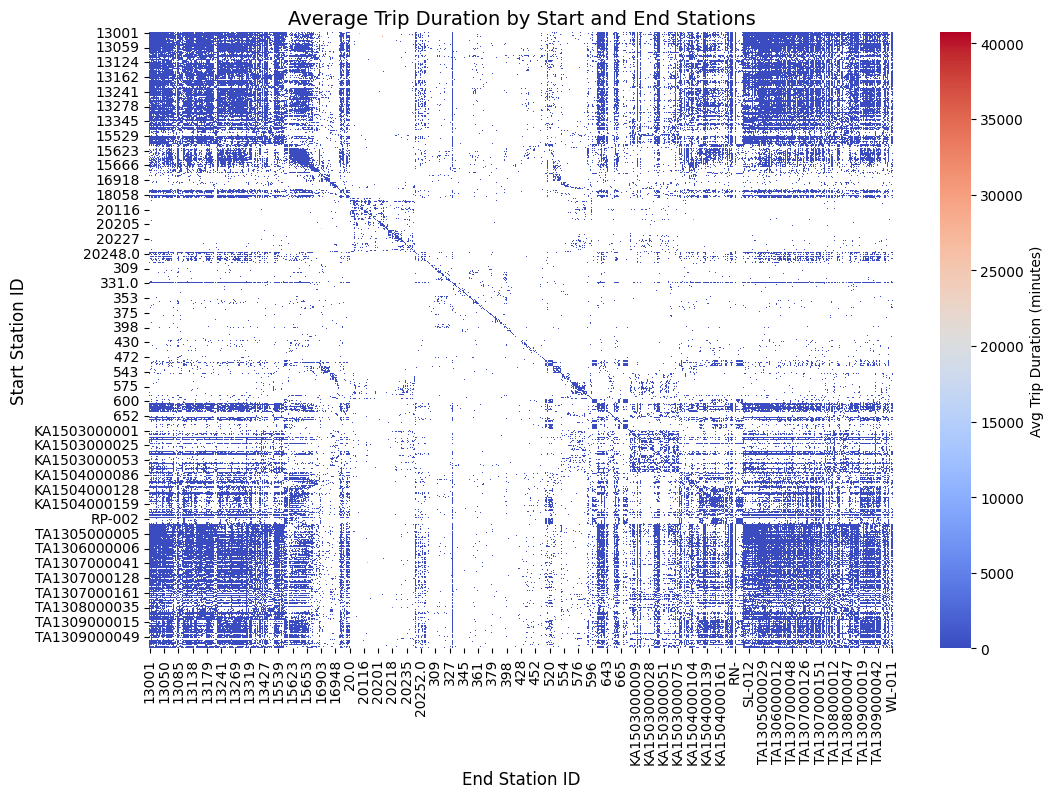

In [0]:
# 2. How much time is spent per ride based on Starting and Ending Stations
spark.sql("""
SELECT 
    start_station_id,
    end_station_id,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
WHERE end_station_id NOT IN ('Hubbard Bike-checking (LBS-WH-TEST)') 
GROUP BY start_station_id, end_station_id
ORDER BY avg_trip_duration DESC;
""").show()

# Query data
station_data = spark.sql("""
SELECT 
    start_station_id,
    end_station_id,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
WHERE end_station_id NOT IN ('Hubbard Bike-checking (LBS-WH-TEST)')
GROUP BY start_station_id, end_station_id
""").toPandas()

# Pivot data for heatmap
heatmap_data = station_data.pivot(index='start_station_id', columns='end_station_id', values='avg_trip_duration')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Avg Trip Duration (minutes)'})
plt.title("Average Trip Duration by Start and End Stations", fontsize=14)
plt.xlabel("End Station ID", fontsize=12)
plt.ylabel("Start Station ID", fontsize=12)
plt.show()

+----------------+------------------+------------------+
|         trip_id|     trip_duration|       distance_km|
+----------------+------------------+------------------+
|69D3FE219C1C5E58| 4.766666666666667|0.6728636273995918|
|DE7D9AC2412A3F78|              3.15|0.4799324673813012|
|CD5FF8486A2AE434|             23.75| 2.406816932566811|
|8D8511E47B4C6B6B|              26.9|3.4588052451307063|
|5A91B1F56B24D18C|33.666666666666664|2.9791581219379224|
|DFE8BD2F817D2344|              21.7|4.9300908045599305|
|ED799FE5092D31E9| 3.283333333333333|0.7539917540708919|
|1EACFCA87D240E82|29.433333333333334| 3.483504512932131|
|E6E715F4FB90440D|12.683333333333334|3.2201328767355757|
|0B4AB24CD90053D6|10.433333333333334| 1.750821639331005|
|79A0805BE634FB9B|16.266666666666666|3.5454185840951333|
|105F84D5DB591F47| 7.366666666666666| 1.159467046513148|
|18F34FF04CDE81AB|             26.55|4.4999426255265895|
|C0524E8346C5332A|63.833333333333336| 10.60634106093959|
|B9FB420E0A7A78BC|15.9666666666

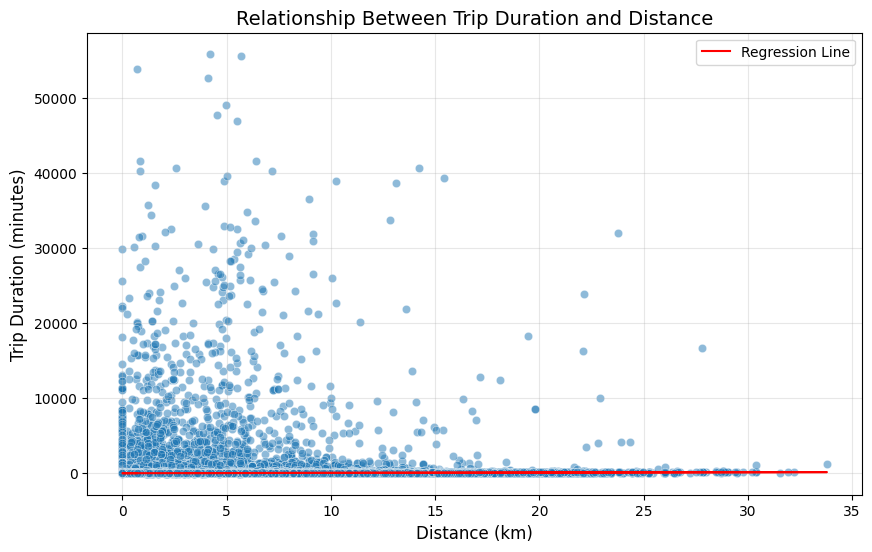

Intercept: 12.409202397409672
Slope: 4.353849981145389 (minutes/km)


In [0]:
spark.sql("""
SELECT 
    r.trip_id,
    r.trip_duration,
    6371 * ACOS(
        COS(RADIANS(ss.latitude)) * COS(RADIANS(es.latitude)) *
        COS(RADIANS(es.longitude) - RADIANS(ss.longitude)) +
        SIN(RADIANS(ss.latitude)) * SIN(RADIANS(es.latitude))
    ) AS distance_km
FROM gold_rides r
JOIN silver_stations ss ON r.start_station_id = ss.station_id
JOIN silver_stations es ON r.end_station_id = es.station_id
WHERE r.trip_duration IS NOT NULL
AND ss.latitude IS NOT NULL AND ss.longitude IS NOT NULL
AND es.latitude IS NOT NULL AND es.longitude IS NOT NULL;
""").show()

# Run the query and fetch results
distance_duration_data = spark.sql("""
SELECT 
    r.trip_id,
    r.trip_duration,
    6371 * ACOS(
        COS(RADIANS(ss.latitude)) * COS(RADIANS(es.latitude)) *
        COS(RADIANS(es.longitude) - RADIANS(ss.longitude)) +
        SIN(RADIANS(ss.latitude)) * SIN(RADIANS(es.latitude))
    ) AS distance_km
FROM gold_rides r
JOIN silver_stations ss ON r.start_station_id = ss.station_id
JOIN silver_stations es ON r.end_station_id = es.station_id
WHERE r.trip_duration IS NOT NULL
AND ss.latitude IS NOT NULL AND ss.longitude IS NOT NULL
AND es.latitude IS NOT NULL AND es.longitude IS NOT NULL;
""").toPandas()

# Drop rows with missing values in 'distance_km' or 'trip_duration'
distance_duration_data = distance_duration_data.dropna(subset=['distance_km', 'trip_duration'])

# Prepare data for regression
X = distance_duration_data['distance_km'].values.reshape(-1, 1)
y = distance_duration_data['trip_duration'].values

# Fit regression model
model = LinearRegression()
model.fit(X, y)

# Predict and plot regression line
predicted_duration = model.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='trip_duration', data=distance_duration_data, alpha=0.5)
plt.plot(distance_duration_data['distance_km'], predicted_duration, color='red', label='Regression Line')
plt.title("Relationship Between Trip Duration and Distance", fontsize=14)
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Trip Duration (minutes)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Print regression coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]} (minutes/km)")

**Observations**
- Dense Cluster of Short Distances: Most trips are clustered around short distances (less than 5 km). These trips exhibit a wide range of durations, indicating diverse usage patterns for short trips:
  - Some short trips are quick commutes.
  - Others are longer (e.g., leisure rides or delayed trips).
- Outliers with Long Durations: There are a few points with very high durations (e.g., > 10,000 minutes) but relatively short distances. These could represent:
  - Bikes left unrented for long periods.
  - GPS or tracking errors.
- Linear Trend: The regression line has a positive slope (~4.35 minutes/km), suggesting a weak linear relationship where longer distances correlate with longer durations. However, the high variability in trip durations, especially for short distances, dilutes the strength of this relationship. 
- Flat Trend Beyond 5 km: For trips over ~5 km, durations tend to stabilize, with less variability. This may reflect longer but more predictable rides, such as commuting or specific routes.

**Insights**
- Short-Distance Trips Dominate: Most trips occur within a short distance, reinforcing the importance of station placement in high-demand areas. These trips are likely dominated by urban commuting or quick errands.
- Duration Outliers Require Investigation: Long durations with short distances should be analyzed further to identify possible issues (e.g., maintenance problems, incomplete returns).
- Predictable Long-Distance Trips: For trips beyond ~5 km, durations become more predictable, likely tied to specific routes or patterns of usage.

+-----------+------------------+
|age_at_ride| avg_trip_duration|
+-----------+------------------+
|         14|13.166666666666666|
|         15|23.441171714781433|
|         16|21.460908236792342|
|         17|21.718526487771765|
|         18| 21.31229212089265|
|         19| 22.52198424019098|
|         20|21.473659313349817|
|         21| 22.61699784135516|
|         22|22.292056798933196|
|         23|21.585633858318563|
|         24| 21.51112222315428|
|         25| 22.09031784988676|
|         26| 22.58605731380884|
|         27| 21.67771037390148|
|         28| 22.21934515636665|
|         29|20.743285942877705|
|         30|22.335822514188788|
|         31|22.233796858202954|
|         32|20.543997406996972|
|         33|23.174145184685166|
+-----------+------------------+
only showing top 20 rows



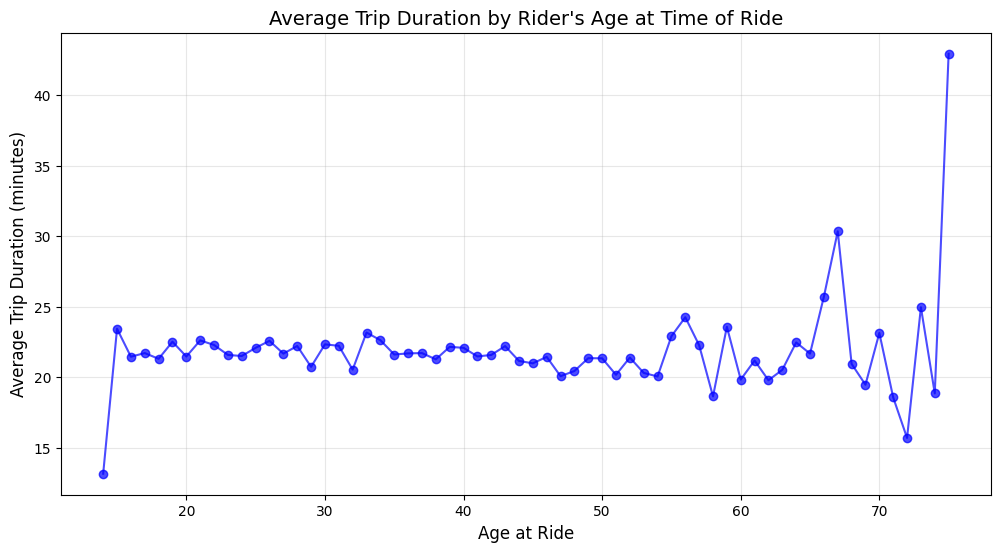

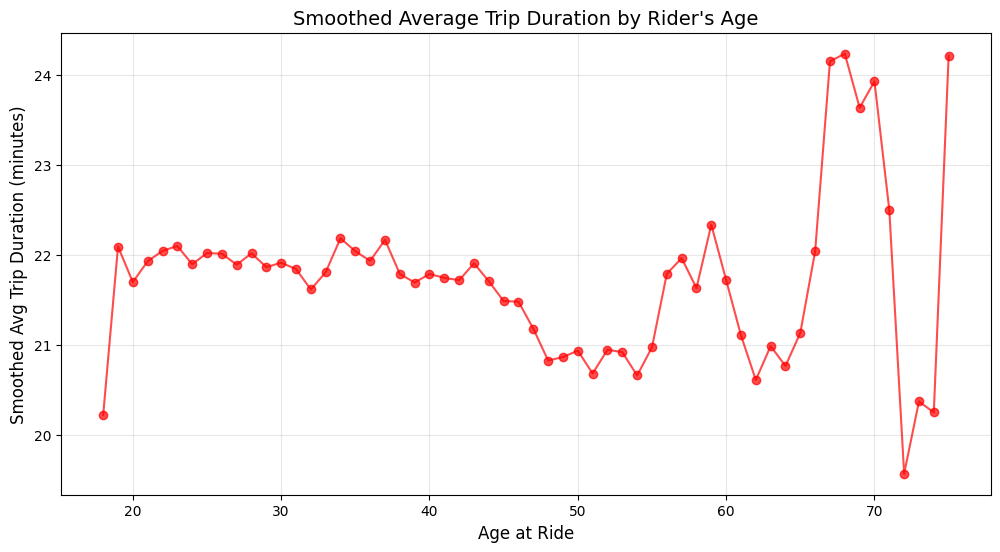

In [0]:
# 3. How much time is spent per ride Based on Age of the Rider at Time of the Ride
spark.sql("""
SELECT 
    age_at_ride,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
WHERE age_at_ride IS NOT NULL
GROUP BY age_at_ride
ORDER BY age_at_ride;
""").show()

# Fetch query result into a Pandas DataFrame
age_trip_duration = spark.sql("""
SELECT 
    age_at_ride,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
WHERE age_at_ride IS NOT NULL
GROUP BY age_at_ride
ORDER BY age_at_ride;
""").toPandas()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(age_trip_duration['age_at_ride'], age_trip_duration['avg_trip_duration'], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title("Average Trip Duration by Rider's Age at Time of Ride", fontsize=14)
plt.xlabel("Age at Ride", fontsize=12)
plt.ylabel("Average Trip Duration (minutes)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Apply rolling average for smoothing
age_trip_duration['smoothed_duration'] = age_trip_duration['avg_trip_duration'].rolling(window=5).mean()

# Smoothed line plot
plt.figure(figsize=(12, 6))
plt.plot(age_trip_duration['age_at_ride'], age_trip_duration['smoothed_duration'], marker='o', linestyle='-', color='red', alpha=0.7)
plt.title("Smoothed Average Trip Duration by Rider's Age", fontsize=14)
plt.xlabel("Age at Ride", fontsize=12)
plt.ylabel("Smoothed Avg Trip Duration (minutes)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

**Observations**
- *Stability Across Young and Middle Ages*: The average trip duration appears relatively stable between ages ~20 to ~50, staying around 21–23 minutes. This suggests that riders in these age groups have consistent travel behaviors. 
- *Fluctuations After Age 50*: After age ~50, the average trip duration begins to fluctuate more. Peaks are visible around ages 60–65, followed by sharp drops and rises.

- *Outliers at Older Ages*: The sudden peaks and troughs around age 70+ could indicate: very small sample sizes for older riders, and outliers (e.g., very short or long trips by individual riders).

+---------+------------------+
|is_member| avg_trip_duration|
+---------+------------------+
|    false|21.323787622308025|
|     true|21.904426867261066|
+---------+------------------+

Mann-Whitney U Test
U-Statistic: 1646629591495.5
P-Value: 2.1416226457211937e-10
There is a statistically significant difference between the two groups.
Members: Median = 12.35, IQR = 15.183333333333335
Casual Riders: Median = 12.25, IQR = 15.083333333333332


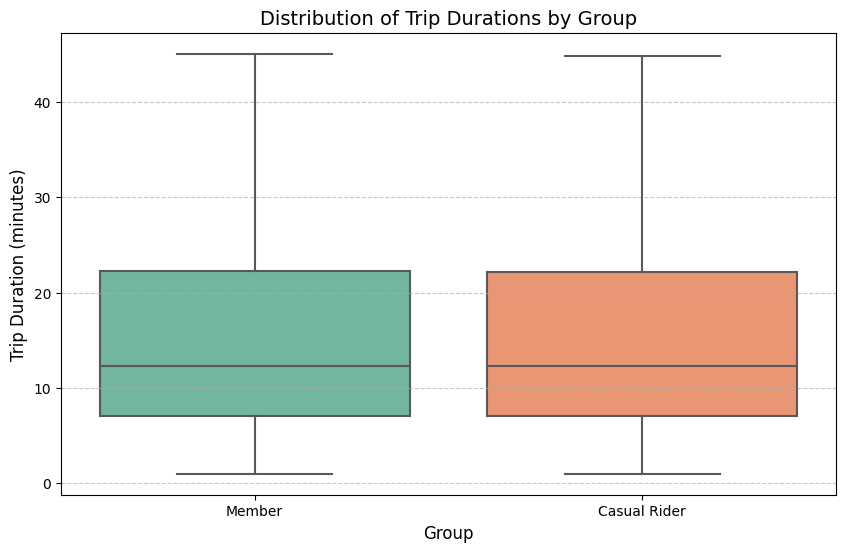

In [0]:
# 4. How much time is spent per ride Based on Membership Status (Member or Casual Rider)
spark.sql("""
SELECT 
    is_member,
    AVG(trip_duration) AS avg_trip_duration
FROM gold_rides
GROUP BY is_member
ORDER BY is_member;
""").show()

# Query data for members and casual riders
data = spark.sql("""
SELECT 
    is_member,
    trip_duration
FROM gold_rides
WHERE trip_duration BETWEEN 1 AND 1440
""").toPandas()

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(members, casual_riders, alternative='two-sided')

print("Mann-Whitney U Test")
print(f"U-Statistic: {stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference between the two groups.")
else:
    print("There is no statistically significant difference between the two groups.")

# Summary statistics for members
members_median = np.median(members)
members_iqr = np.percentile(members, 75) - np.percentile(members, 25)

# Summary statistics for casual riders
casual_median = np.median(casual_riders)
casual_iqr = np.percentile(casual_riders, 75) - np.percentile(casual_riders, 25)

print(f"Members: Median = {members_median}, IQR = {members_iqr}")
print(f"Casual Riders: Median = {casual_median}, IQR = {casual_iqr}")

# Combine data for visualization
data['Group'] = data['is_member'].map({True: 'Member', False: 'Casual Rider'})

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='trip_duration', data=data, showfliers=False, palette="Set2")
plt.title("Distribution of Trip Durations by Group", fontsize=14)
plt.xlabel("Group", fontsize=12)
plt.ylabel("Trip Duration (minutes)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Insights**
- *Small Practical Difference*: Although the statistical test shows a significant difference, the practical difference is negligible based on this visualization and the medians. Both groups exhibit highly similar trip duration behaviors.
- *Business Implications*: With such similar behavior, casual riders might be targeted for conversion to membership through benefits like cost savings or additional perks. Also, since both groups behave similarly, service enhancements (e.g., station availability, bike quality) can benefit all users equally without needing to tailor for specific groups.

+----+-------+-----+------------------+
|year|quarter|month|       total_spent|
+----+-------+-----+------------------+
|2013|      1|    2|              12.9|
|2013|      1|    3|            817.75|
|2013|      2|    4|           1672.65|
|2013|      2|    5|           2716.71|
|2013|      2|    6|3775.2999999999997|
|2013|      3|    7| 4760.959999999999|
|2013|      3|    8|            5834.3|
|2013|      3|    9|            6672.1|
|2013|      4|   10|           7886.12|
|2013|      4|   11|           9195.45|
|2013|      4|   12|10349.100000000002|
|2014|      1|    1|11471.640000000001|
|2014|      1|    2|12584.920000000002|
|2014|      1|    3|          13385.36|
|2014|      2|    4|          15351.43|
|2014|      2|    5|          16802.17|
|2014|      2|    6|18110.539999999997|
|2014|      3|    7|          19542.47|
|2014|      3|    8|20891.409999999996|
|2014|      3|    9|22526.930000000004|
+----+-------+-----+------------------+
only showing top 20 rows



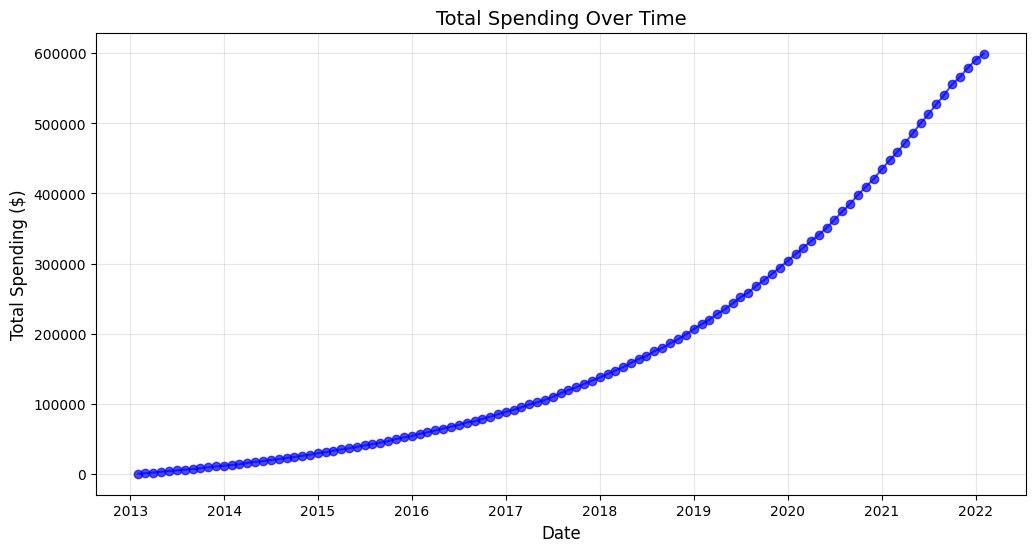

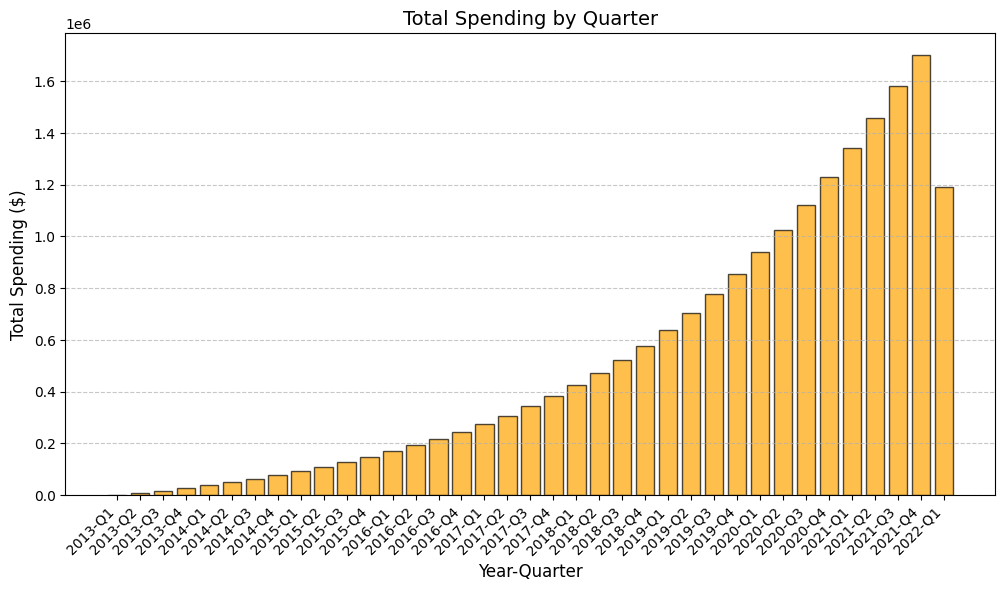

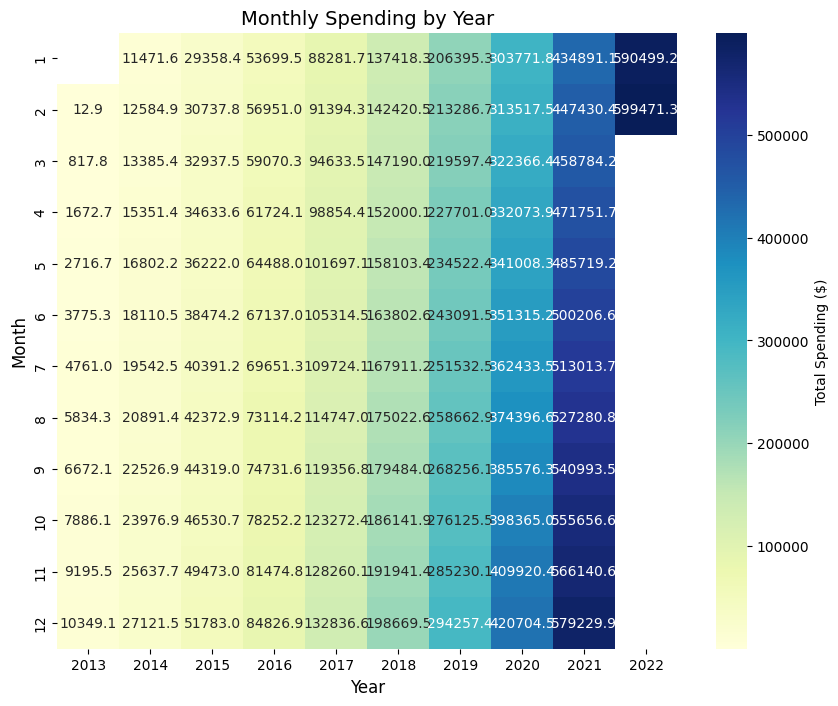

In [0]:
# 5. How much money is spent Per Month, Quarter, Year
spark.sql("""
SELECT 
    year,
    quarter,
    month,
    SUM(total_spent) AS total_spent
FROM gold_spending
GROUP BY year, quarter, month
ORDER BY year, quarter, month;
""").show()

# Fetch the query result into a Pandas DataFrame
spending_data = spark.sql("""
SELECT 
    year,
    quarter,
    month,
    SUM(total_spent) AS total_spent
FROM gold_spending
GROUP BY year, quarter, month
ORDER BY year, quarter, month;
""").toPandas()

# Combine year and month into a single datetime column
spending_data['date'] = pd.to_datetime(spending_data['year'].astype(str) + '-' + spending_data['month'].astype(str) + '-01')

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(spending_data['date'], spending_data['total_spent'], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title("Total Spending Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Spending ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Aggregate spending by quarter and year
quarterly_spending = spending_data.groupby(['year', 'quarter'], as_index=False)['total_spent'].sum()

# Create a combined label for year and quarter
quarterly_spending['year_quarter'] = quarterly_spending['year'].astype(str) + '-Q' + quarterly_spending['quarter'].astype(str)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(quarterly_spending['year_quarter'], quarterly_spending['total_spent'], color='orange', edgecolor='black', alpha=0.7)
plt.title("Total Spending by Quarter", fontsize=14)
plt.xlabel("Year-Quarter", fontsize=12)
plt.ylabel("Total Spending ($)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Pivot the data for heatmap
heatmap_data = spending_data.pivot(index='month', columns='year', values='total_spent')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Total Spending ($)'})
plt.title("Monthly Spending by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Month", fontsize=12)
plt.show()

**Observations**
1. Exponential Growth: The total spending grows at an increasing rate, especially noticeable after ~2018. This suggests a growing user base or increased spending per user over time.

2. No Major Seasonal Fluctuations: The growth appears smooth without noticeable dips or spikes, which indicates that spending is steadily increasing rather than being tied to seasonal changes.

3. Steeper Growth in Recent Years: Post-2020, the curve becomes steeper, suggesting accelerated growth. Possible reasons could include:
    - Increased user adoption.
    - Price adjustments.
    - Expansion of services or geographic coverage.


**Insights**
1. Business Growth: The steady increase in spending indicates strong business growth and sustained customer engagement.
2. Long-Term Revenue Projections: This trend can be used for revenue forecasting, assuming similar growth rates continue.
3. Impact of External Factors: Events like new promotions, price changes, or external factors (e.g., a pandemic) may explain the steep growth in recent years.

+--------------------+------------------+
|age_at_account_start|         avg_spent|
+--------------------+------------------+
|                   7|10.335448348190878|
|                   8| 10.28722241867044|
|                   9|10.056370212765957|
|                  10| 9.912273879479205|
|                  11|10.109427709507122|
|                  12|   9.9600146248872|
|                  13|10.127190359028255|
|                  14| 9.956331363333804|
|                  15| 9.963506544213763|
|                  16| 9.960220749788075|
|                  17|10.046420121898878|
|                  18|10.039007474690134|
|                  19|  9.98043533686024|
|                  20| 9.983823750440937|
|                  21| 9.962424082154346|
|                  22| 9.980132168248307|
|                  23|  9.98924657229015|
|                  24|10.021783912844112|
|                  25| 9.949486122347386|
|                  26|10.123133214343666|
+--------------------+------------

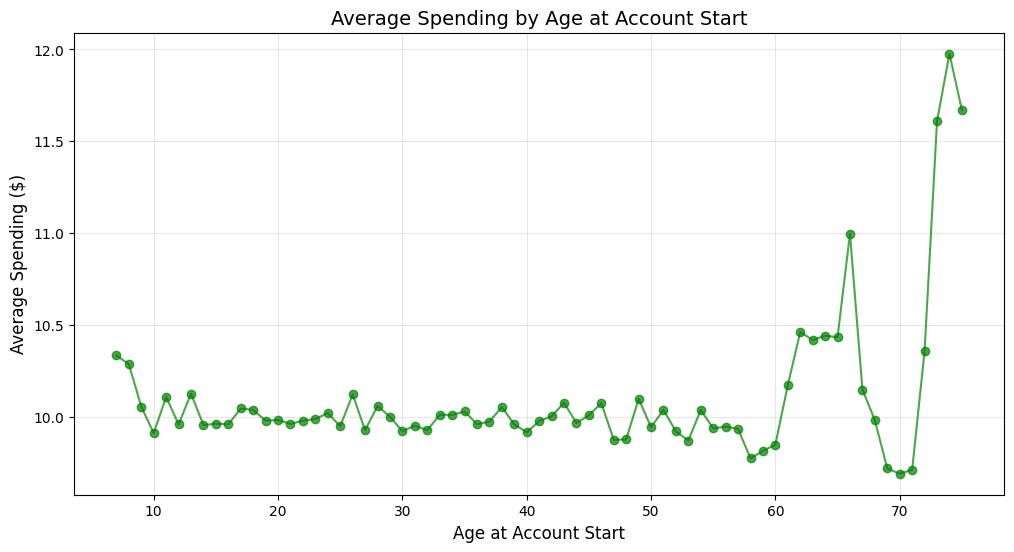

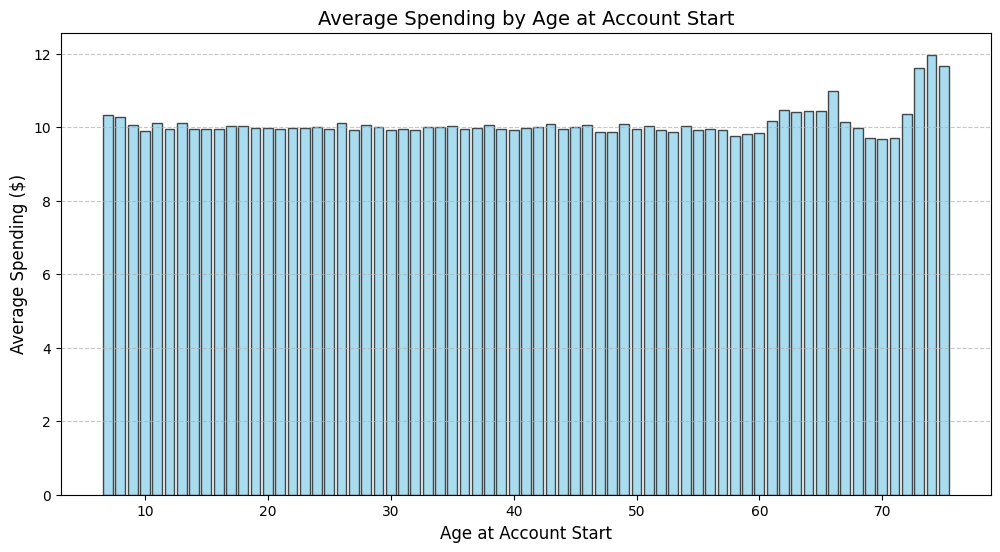

In [0]:
# 6. Per Member, Based on Age at Account Start
spark.sql("""
SELECT 
    age_at_account_start,
    AVG(total_spent) AS avg_spent
FROM gold_spending
WHERE age_at_account_start IS NOT NULL
GROUP BY age_at_account_start
ORDER BY age_at_account_start;
""").show()

# Query data
spending_by_age = spark.sql("""
SELECT 
    age_at_account_start,
    AVG(total_spent) AS avg_spent
FROM gold_spending
WHERE age_at_account_start IS NOT NULL
GROUP BY age_at_account_start
ORDER BY age_at_account_start;
""").toPandas()

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(spending_by_age['age_at_account_start'], spending_by_age['avg_spent'], marker='o', linestyle='-', color='green', alpha=0.7)
plt.title("Average Spending by Age at Account Start", fontsize=14)
plt.xlabel("Age at Account Start", fontsize=12)
plt.ylabel("Average Spending ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(spending_by_age['age_at_account_start'], spending_by_age['avg_spent'], color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Average Spending by Age at Account Start", fontsize=14)
plt.xlabel("Age at Account Start", fontsize=12)
plt.ylabel("Average Spending ($)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The two plots — a line plot and a bar chart — provide useful insights into average spending based on age at account start. 

**Observations from the Line Plot**
- Stable Spending Across Most Ages:For ages ~10 to ~50, average spending remains relatively stable, hovering around $10–$10.5. This indicates that younger and middle-aged members behave similarly in terms of spending.
- Notable Increase for Older Ages: After age ~60, there is a significant increase in spending, with members starting accounts at ages ~70 spending upwards of $12 on average. This is probably related to a smaller sample sizes at older ages, skewing the average.

**Observations from the Bar Chart**
- Consistency: The bar chart confirms that most age groups have very similar average spending. Variations are minor until age 60+, where spending increases. 
- Emphasis on Older Members: The increasing trend for ages 60+ is visually clear, emphasizing their higher spending compared to younger members.

**Insights**
- Key Age Groups:
  - Members aged 10–50 exhibit stable spending behavior. Members aged 60+ represent a distinct segment with higher average spending.
  - Potential Sample Size Issue: Older age groups (e.g., 70+) have fewer members, leading to higher variability in spending averages.

- Targeted Marketing:
  - Younger and middle-aged members (~10–50) can be targeted with general campaigns since their spending is consistent.
  - Older members (60+) may benefit from tailored campaigns focusing on their unique needs or preferences.

- Segment by Membership Type: 
  - Separate spending patterns for members and casual riders to see if older casual riders spend more on one-off trips.
